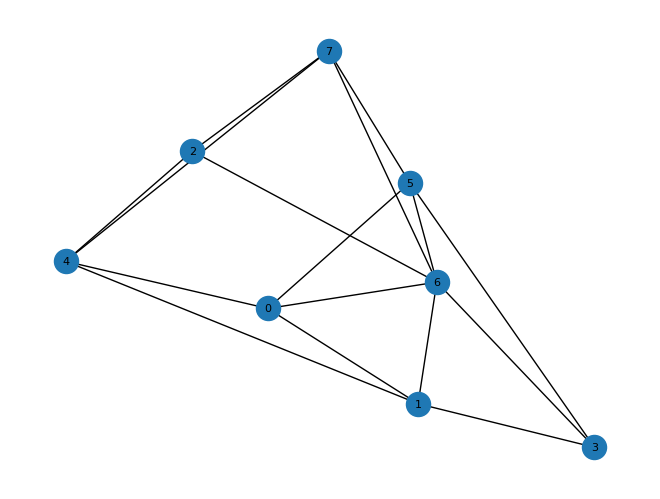

In [172]:
import networkx as nx
import random
import matplotlib.pyplot as plt

n = 8

graph = nx.Graph()

graph.add_nodes_from(range(n))

nodes = list(range(n))
random.shuffle(nodes)

for i in range(n - 1):
    weight = round(random.uniform(0.1, 10.0), 2)
    graph.add_edge(nodes[i], nodes[i + 1], weight=weight)

num_extra_edges = random.randint(0, n) 
while len(graph.edges) < n + num_extra_edges:
    u, v = random.sample(range(n), 2)
    if not graph.has_edge(u, v):
        weight = round(random.uniform(0.1, 10.0), 2)
        graph.add_edge(u, v, weight=weight)

nx.draw(graph, with_labels=True, node_size=300, font_size=8)
plt.show()
edge_list = [(u, v, data['weight']) for u, v, data in graph.edges(data=True)]

In [173]:
# n = 5
# edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]

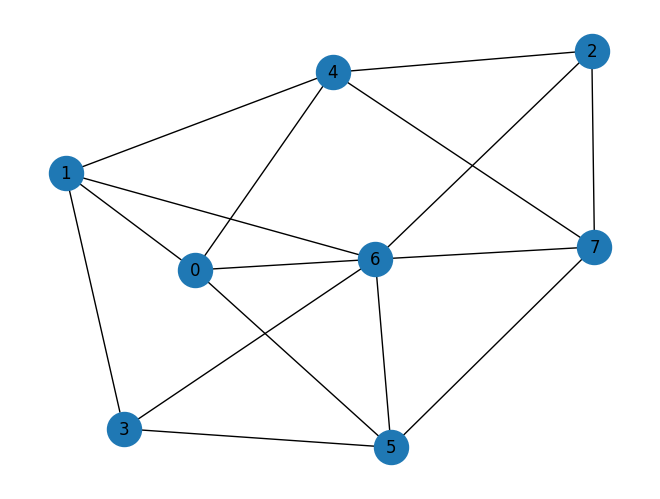

In [174]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [175]:
from qiskit.quantum_info import SparsePauliOp
def build_hamiltonian(n, edge_list):
    pauli_list = []
    for (i, j, weight) in edge_list:
        pauli_list.append(["I"] * n)
        pauli_list[-1][i] = "Z"
        pauli_list[-1][j] = "Z"
        pauli_list[-1] = ("".join(pauli_list[-1])[::-1], weight)
    return SparsePauliOp.from_list(pauli_list)

In [176]:
print("Cost Function Hamiltonian:", build_hamiltonian(n, edge_list))

Cost Function Hamiltonian: SparsePauliOp(['IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'IIIIIIZZ', 'IIIIZIZI', 'IZIIIIZI', 'IIIZIIZI', 'ZIIIIZII', 'IZIIIZII', 'IIIZIZII', 'IIZIZIII', 'IZIIZIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[6.61+0.j, 7.99+0.j, 3.09+0.j, 7.5 +0.j, 8.85+0.j, 8.8 +0.j, 0.94+0.j,
 6.66+0.j, 4.96+0.j, 6.85+0.j, 0.35+0.j, 3.21+0.j, 0.26+0.j, 9.86+0.j,
 7.13+0.j, 0.56+0.j])


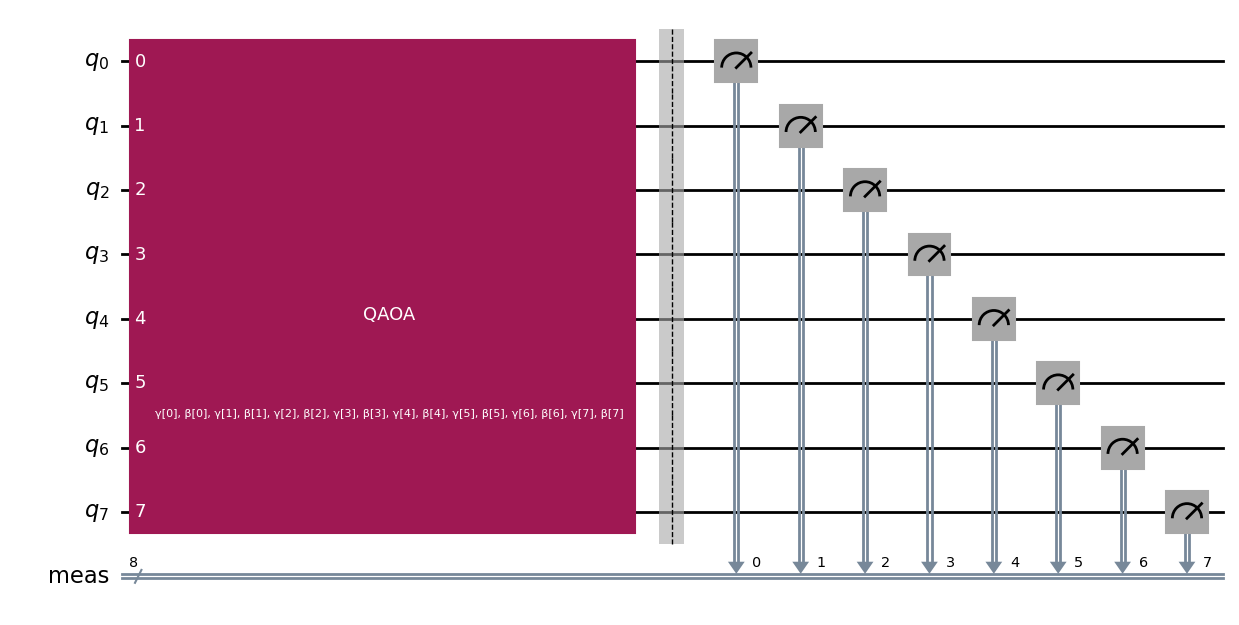

In [177]:
from qiskit.circuit.library import QAOAAnsatz
repeat_time = 8
circuit = QAOAAnsatz(cost_operator=build_hamiltonian(n, edge_list), reps=repeat_time)
circuit.measure_all()

circuit.draw('mpl')

In [178]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7])])

AerSimulator('aer_simulator')


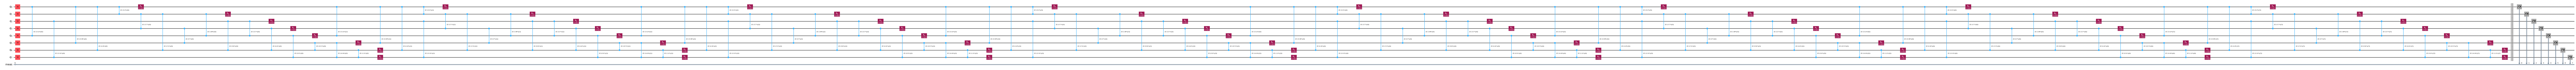

In [179]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator


# 使用 AerSimulator 作为本地后端
backend = AerSimulator()

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
print(backend)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [180]:
import numpy as np
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_beta] * repeat_time + [initial_gamma] * repeat_time

In [181]:
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    print(len(objective_func_vals), "th iteration's cost: ", objective_func_vals[-1])
    return cost

In [182]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
objective_func_vals = []
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    # estimator = Estimator(mode=session)
    # estimator.options.default_shots = 1000
    # # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"
    estimator = Estimator()
    estimator.options.default_shots = 1000
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, build_hamiltonian(n, edge_list), estimator),
        method="COBYLA",
        tol=1e-8,
    )
    print(result)

1 th iteration's cost:  -0.3576423576423578
2 th iteration's cost:  -3.028231768231768
3 th iteration's cost:  1.6817782217782211
4 th iteration's cost:  0.7516283716283718
5 th iteration's cost:  -0.19568431568431566
6 th iteration's cost:  1.5445754245754255
7 th iteration's cost:  -0.42327672327672294
8 th iteration's cost:  -0.6132867132867136
9 th iteration's cost:  -2.9210389610389615
10 th iteration's cost:  -5.322977022977023
11 th iteration's cost:  -6.397262737262738
12 th iteration's cost:  -4.744395604395605
13 th iteration's cost:  -5.885054945054945
14 th iteration's cost:  -6.0498301698301695
15 th iteration's cost:  -6.82
16 th iteration's cost:  -5.448171828171829
17 th iteration's cost:  -6.165714285714286
18 th iteration's cost:  -1.3493506493506493
19 th iteration's cost:  1.1909690309690308
20 th iteration's cost:  -5.187812187812188
21 th iteration's cost:  2.997262737262737
22 th iteration's cost:  -0.30863136863136925
23 th iteration's cost:  -6.961478521478521


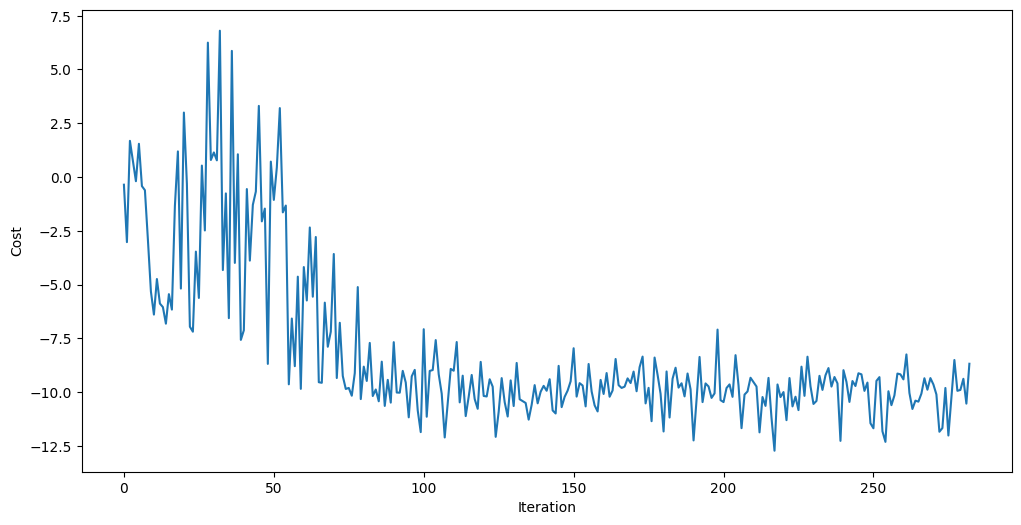

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

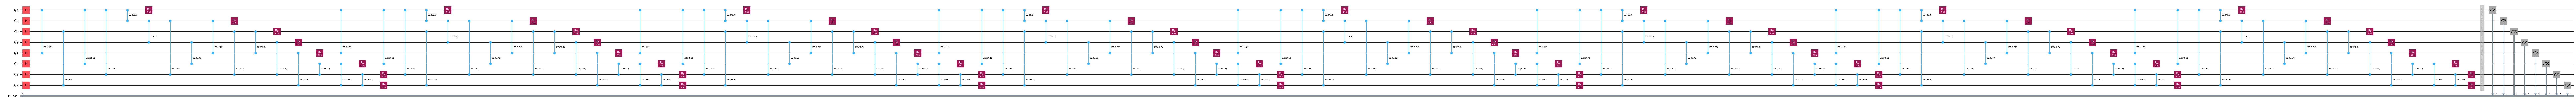

In [184]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [185]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
# print(final_distribution_int)

In [186]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 1, 0, 1, 1]


In [187]:
# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams.update({"font.size": 10})
# final_bits = final_distribution_bin
# values = np.abs(list(final_bits.values()))
# top_4_values = sorted(values, reverse=True)[:4]
# positions = []
# for value in top_4_values:
#     positions.append(np.where(values == value)[0])
# fig = plt.figure(figsize=(11, 6))
# ax = fig.add_subplot(1, 1, 1)
# plt.xticks(rotation=45)
# plt.title("Result Distribution")
# plt.xlabel("Bitstrings (reversed)")
# plt.ylabel("Probability")
# ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
# for p in positions:
#     ax.get_children()[int(p)].set_color("tab:purple")
# plt.show()

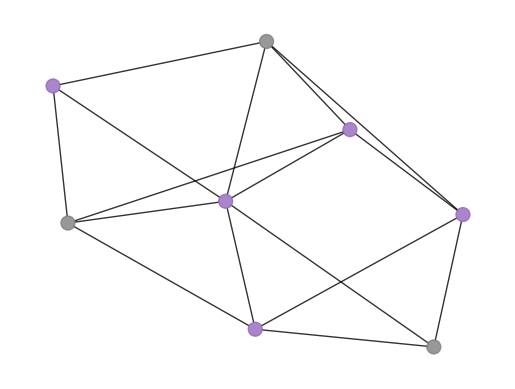

In [188]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [189]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum((x[u] * (1 - x[v]) + x[v] * (1 - x[u])) * weight for u, v, weight in edge_list)


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 69.89


In [190]:
def max_cut_from_edge_list(edge_list):
    # 提取节点集合
    nodes = set()
    for u, v, _ in edge_list:
        nodes.add(u)
        nodes.add(v)
    nodes = list(nodes)

    # 初始化：随机分配节点到两个集合
    partition = {node: random.choice([0, 1]) for node in nodes}

    def calculate_cut_value(partition):
        """计算当前划分的割值"""
        cut_value = 0
        for u, v, weight in edge_list:
            if partition[u] != partition[v]:  # 如果 u 和 v 在不同集合中
                cut_value += weight
        return cut_value

    # 记录当前最优的割值和对应划分
    best_cut_value = calculate_cut_value(partition)
    best_partition = partition.copy()

    # 随机局部搜索
    for _ in range(100000):  # 最大迭代次数
        # 随机选择一个节点并切换其集合
        node = random.choice(nodes)
        partition[node] = 1 - partition[node]  # 切换集合

        # 计算新的割值
        current_cut_value = calculate_cut_value(partition)

        if current_cut_value > best_cut_value:
            # 更新最优解
            best_cut_value = current_cut_value
            best_partition = partition.copy()
        else:
            # 恢复更改
            partition[node] = 1 - partition[node]

    return best_cut_value, best_partition

# 寻找 Max-Cut
max_cut_value, partition = max_cut_from_edge_list(edge_list)

# 输出结果
print("Max-Cut Value:", max_cut_value)
print("Partition:", partition)

Max-Cut Value: 69.89
Partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0}
